<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML2/blob/main/RandomForest/NASDAQ_Selection_Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Chargement et correction des données

Le dataset utilisé contient les prix des actions des 81 principales compagnies du NASDAQ100. La valeur de l'index du NASDAQ est utilisé comme cible.  
La fréquence des information est d'une minute, depuis le 26 juillet 2016 jusqu'au 22 décembre 2016, soit 105 jours au total (les samedi et dimanche ne sont pas comptés, ainsi que le 25 novembre qui ne possède que 210 données et le 22 décembre qui n'en possède que 180).

**1. Chargement des données**

In [2]:
!rm *.csv
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/nasdaq100_padding.csv"

rm: cannot remove '*.csv': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   184  100   184    0     0   1628      0 --:--:-- --:--:-- --:--:--  1628
100 22.6M  100 22.6M    0     0  32.6M      0 --:--:-- --:--:-- --:--:--  143M


**2. Analyse et correction des données**

In [3]:
# Création de la série sous Pandas
df_etude = pd.read_csv("nasdaq100_padding.csv",dtype="float32")
df_etude

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,AMZN,ATVI,AVGO,BBBY,BIDU,BIIB,CA,CELG,CERN,CMCSA,COST,CSCO,CSX,CTRP,CTSH,DISCA,DISH,DLTR,EA,EBAY,ESRX,EXPE,FAST,FB,FOX,FOXA,GILD,GOOGL,INTC,JD,...,LBTYK,LRCX,MAR,MAT,MCHP,MDLZ,MSFT,MU,MXIM,MYL,NCLH,NFLX,NTAP,NVDA,NXPI,PAYX,PCAR,PYPL,QCOM,QVCA,ROST,SBUX,SIRI,STX,SWKS,SYMC,TMUS,TRIP,TSCO,TSLA,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.980000,96.800003,97.800003,61.150002,95.400002,58.180000,58.000000,127.040001,26.680000,165.809998,742.119995,42.299999,161.410004,44.209999,159.889999,286.320007,34.570000,106.050003,62.070000,67.339996,167.600006,30.790001,28.370001,43.520000,58.400002,25.420000,52.439999,96.550003,76.949997,30.600000,76.540001,117.879997,41.990002,121.940002,27.500000,26.860001,84.000000,756.570007,34.770000,21.799999,...,30.209999,91.239998,71.110001,32.779999,54.779999,45.689999,56.514999,14.000000,39.200001,47.130001,41.900002,91.000000,26.440001,56.198399,85.230003,60.740002,56.169998,37.770000,60.950001,26.740000,61.130001,58.578999,4.280,31.350000,65.360001,20.370001,44.950001,70.050003,91.410004,227.649994,70.730003,45.230000,31.170099,95.269997,81.364998,52.160000,33.950001,48.610001,38.009998,4665.054199
1,35.931000,96.889999,97.800003,61.610001,95.411499,58.189999,58.119999,126.059998,26.730000,165.910095,741.919983,42.439999,161.830002,44.090000,160.130005,286.809998,34.580002,105.544998,61.930000,67.300003,167.820007,30.840000,28.462500,43.520000,58.330002,25.410000,52.110001,96.820000,77.070000,30.740000,76.440002,117.989998,41.900002,121.745003,27.480000,26.870001,83.970001,756.159973,34.919998,21.850000,...,30.430000,91.330002,70.849998,32.790001,54.889999,45.730000,56.720001,14.000000,39.369999,47.150002,41.810001,91.160004,26.450001,56.415001,86.175003,60.935001,56.849998,37.740002,60.919998,26.719999,61.430000,58.480000,4.270,31.010000,65.250000,20.410000,44.974998,70.230003,91.050003,227.096695,70.690002,45.009998,31.190001,94.169998,81.540001,52.150002,34.099998,48.740002,38.139999,4665.054199
2,35.904400,96.949997,97.570000,61.980000,95.510002,58.203335,57.950001,126.510002,26.712000,166.179993,739.599976,42.459999,162.500000,43.860001,160.000000,286.130005,34.590000,106.578697,61.916668,67.230003,167.960007,30.879999,28.389999,43.540001,58.340000,25.379999,52.106667,96.889999,77.250000,30.799999,76.089996,118.629997,41.735001,121.452003,27.410000,26.820000,84.000000,755.619995,34.919201,21.770000,...,30.170000,91.370003,70.779999,32.830002,55.139999,45.799999,56.700001,14.005600,39.380001,47.130001,41.865002,91.360001,26.389999,56.490002,85.680099,61.000000,57.500000,37.711700,61.029999,26.660000,61.549999,58.509998,4.285,31.195000,65.410004,20.389999,44.810001,70.092499,91.180000,226.630005,71.300003,45.014999,31.209999,94.749001,81.529999,52.270000,34.009998,48.990002,38.150002,4665.826172
3,35.889999,96.970001,97.550003,62.090000,95.519997,58.216667,57.959999,126.279999,26.740000,166.147995,739.549988,42.520000,162.679993,43.799999,160.119995,286.799988,34.610001,106.349998,61.903332,67.379997,167.850006,30.889999,28.389999,43.549999,58.540001,25.370001,52.103333,96.760002,76.959999,30.860001,75.650002,118.570000,41.709999,121.449997,27.420000,26.870001,83.339996,756.359924,34.951000,21.809999,...,30.100000,91.419998,70.875000,32.860001,55.310001,45.790001,56.689999,14.057300,39.419998,47.115002,41.919998,92.279999,26.395500,56.533501,85.665001,61.007999,57.750000,37.825001,61.130001,26.730000,61.500000,58.470001,4.280,31.139999,65.239998,20.370001,44.689999,69.955002,91.279999,227.529999,71.309998,45.020000,31.209999,94.309998,81.709999,52.299999,33.959999,48.950001,38.195000,4667.081055
4,36.007999,96.959999,97.730003,61.889999,95.529999,58.230000,58.209999,126.584999,26.719999,165.990005,738.719971,42.610001,162.750000,43.919998,160.860001,286.420013,34.619999,106.000000,61.889999,67.300003,168.440002,30.875000,28.389999,43.630001,58.560001,25.320000,52.099998,96.760002,77.029999,30.889999,76.500000,118.419998,41.820000,121.379997,

Affiche les types :

In [4]:
df_etude.dtypes

AAL     float32
AAPL    float32
ADBE    float32
ADI     float32
ADP     float32
         ...   
WDC     float32
WFM     float32
XLNX    float32
YHOO    float32
NDX     float32
Length: 82, dtype: object

**5. Affiche les données**

In [5]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_etude),len(df_etude)+1),y=df_etude['NDX'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Corrélations entre les variables

**1. Corrélation de l'ensemble des variables**

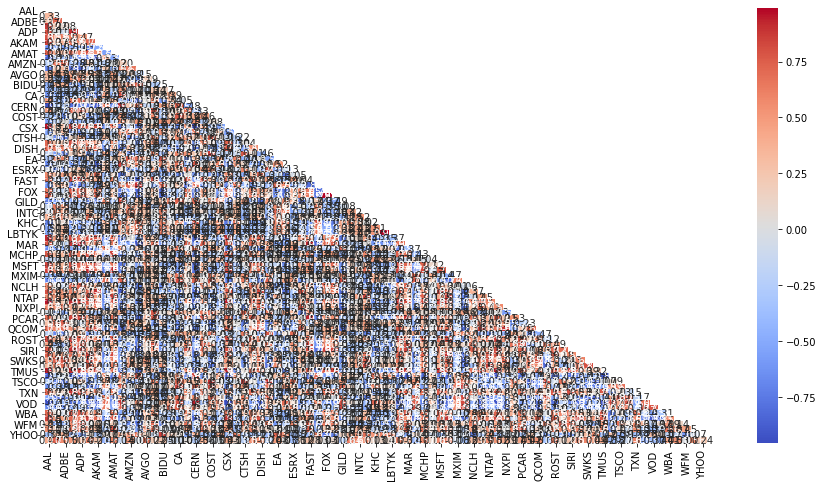

In [ ]:
import seaborn as sns

corr = df_etude.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

# Identification des variables les plus importantes par Random Forest

**1. Création des données X et Y**

In [8]:
X = df_etude.iloc[:,0:-1]
X

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,AMZN,ATVI,AVGO,BBBY,BIDU,BIIB,CA,CELG,CERN,CMCSA,COST,CSCO,CSX,CTRP,CTSH,DISCA,DISH,DLTR,EA,EBAY,ESRX,EXPE,FAST,FB,FOX,FOXA,GILD,GOOGL,INTC,JD,...,LBTYA,LBTYK,LRCX,MAR,MAT,MCHP,MDLZ,MSFT,MU,MXIM,MYL,NCLH,NFLX,NTAP,NVDA,NXPI,PAYX,PCAR,PYPL,QCOM,QVCA,ROST,SBUX,SIRI,STX,SWKS,SYMC,TMUS,TRIP,TSCO,TSLA,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO
0,35.980000,96.800003,97.800003,61.150002,95.400002,58.180000,58.000000,127.040001,26.680000,165.809998,742.119995,42.299999,161.410004,44.209999,159.889999,286.320007,34.570000,106.050003,62.070000,67.339996,167.600006,30.790001,28.370001,43.520000,58.400002,25.420000,52.439999,96.550003,76.949997,30.600000,76.540001,117.879997,41.990002,121.940002,27.500000,26.860001,84.000000,756.570007,34.770000,21.799999,...,31.100,30.209999,91.239998,71.110001,32.779999,54.779999,45.689999,56.514999,14.000000,39.200001,47.130001,41.900002,91.000000,26.440001,56.198399,85.230003,60.740002,56.169998,37.770000,60.950001,26.740000,61.130001,58.578999,4.280,31.350000,65.360001,20.370001,44.950001,70.050003,91.410004,227.649994,70.730003,45.230000,31.170099,95.269997,81.364998,52.160000,33.950001,48.610001,38.009998
1,35.931000,96.889999,97.800003,61.610001,95.411499,58.189999,58.119999,126.059998,26.730000,165.910095,741.919983,42.439999,161.830002,44.090000,160.130005,286.809998,34.580002,105.544998,61.930000,67.300003,167.820007,30.840000,28.462500,43.520000,58.330002,25.410000,52.110001,96.820000,77.070000,30.740000,76.440002,117.989998,41.900002,121.745003,27.480000,26.870001,83.970001,756.159973,34.919998,21.850000,...,31.225,30.430000,91.330002,70.849998,32.790001,54.889999,45.730000,56.720001,14.000000,39.369999,47.150002,41.810001,91.160004,26.450001,56.415001,86.175003,60.935001,56.849998,37.740002,60.919998,26.719999,61.430000,58.480000,4.270,31.010000,65.250000,20.410000,44.974998,70.230003,91.050003,227.096695,70.690002,45.009998,31.190001,94.169998,81.540001,52.150002,34.099998,48.740002,38.139999
2,35.904400,96.949997,97.570000,61.980000,95.510002,58.203335,57.950001,126.510002,26.712000,166.179993,739.599976,42.459999,162.500000,43.860001,160.000000,286.130005,34.590000,106.578697,61.916668,67.230003,167.960007,30.879999,28.389999,43.540001,58.340000,25.379999,52.106667,96.889999,77.250000,30.799999,76.089996,118.629997,41.735001,121.452003,27.410000,26.820000,84.000000,755.619995,34.919201,21.770000,...,31.010,30.170000,91.370003,70.779999,32.830002,55.139999,45.799999,56.700001,14.005600,39.380001,47.130001,41.865002,91.360001,26.389999,56.490002,85.680099,61.000000,57.500000,37.711700,61.029999,26.660000,61.549999,58.509998,4.285,31.195000,65.410004,20.389999,44.810001,70.092499,91.180000,226.630005,71.300003,45.014999,31.209999,94.749001,81.529999,52.270000,34.009998,48.990002,38.150002
3,35.889999,96.970001,97.550003,62.090000,95.519997,58.216667,57.959999,126.279999,26.740000,166.147995,739.549988,42.520000,162.679993,43.799999,160.119995,286.799988,34.610001,106.349998,61.903332,67.379997,167.850006,30.889999,28.389999,43.549999,58.540001,25.370001,52.103333,96.760002,76.959999,30.860001,75.650002,118.570000,41.709999,121.449997,27.420000,26.870001,83.339996,756.359924,34.951000,21.809999,...,30.900,30.100000,91.419998,70.875000,32.860001,55.310001,45.790001,56.689999,14.057300,39.419998,47.115002,41.919998,92.279999,26.395500,56.533501,85.665001,61.007999,57.750000,37.825001,61.130001,26.730000,61.500000,58.470001,4.280,31.139999,65.239998,20.370001,44.689999,69.955002,91.279999,227.529999,71.309998,45.020000,31.209999,94.309998,81.709999,52.299999,33.959999,48.950001,38.195000
4,36.007999,96.959999,97.730003,61.889999,95.529999,58.230000,58.209999,126.584999,26.719999,165.990005,738.719971,42.610001,162.750000,43.919998,160.860001,286.420013,34.619999,106.000000,61.889999,67.300003,168.440002,30.875000,28.389999,43.630001,58.560001,25.320000,52.099998,96.760002,77.029999,30.889999,76.500000,118.419998,41.820000,121.379997,27.400000,26.83000

In [9]:
Y = df_etude.iloc[:,-1:]
Y

,NDX
0,4665.054199
1,4665.054199
2,4665.826172
3,4667.081055
4,4664.491211
...,...
40555,4921.811035
40556,4921.580078
40557,4921.883789
40558,4922.949219


**1. Choix du nombre d'arbres**

On commence par regarder comment évolue le score sur une 10ène d'essais avec un nombre d'arbres croissant :

In [ ]:
# Informations sur les données
n = 40560             # Nombre d'observations
p = 81                # Nombre de variables

n_arbres_max = 2000

n_arbres = np.linspace(50,n_arbres_max,10).astype(np.int32)
mtry = np.sqrt(p).astype(np.int32)
OOB_err = []

for i in n_arbres:
  print("#Arbres : %d" %i)
  clf = RandomForestRegressor(n_estimators=i, bootstrap=True, oob_score=True, max_samples = n, max_features = mtry, n_jobs=-1)
  clf.fit(X,tf.squeeze(np.asarray(Y),1))
  OOB_err.append(1 - clf.oob_score_)

#Arbres : 50
#Arbres : 266
#Arbres : 483
#Arbres : 700
#Arbres : 916
#Arbres : 1133
#Arbres : 1350
#Arbres : 1566
#Arbres : 1783
#Arbres : 2000


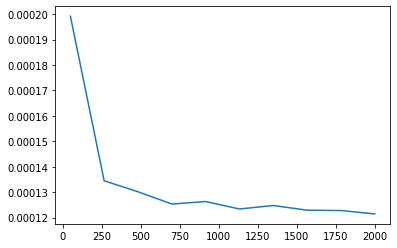

In [ ]:
plt.plot(n_arbres,OOB_err)

On choisir n_arbres = 2000 et on utilise m_try = 81

# Importance des variables - Pemière approche : Importance sans permutations

**1. Entrainement de la forêt**

In [10]:
from sklearn.inspection import permutation_importance

# Informations sur les données
n = 40560             # Nombre d'observations
p = 81                # Nombre de variables
n_arbres = 2000
m_try = p

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)
clf.fit(X,tf.squeeze(np.asarray(Y),1))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=81, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

**2. Affichage de l'importance des variables**

In [11]:
col_sorted_by_importance=clf.feature_importances_.argsort()
feat_imp = pd.DataFrame({'cols':X.columns[col_sorted_by_importance],'imps':clf.feature_importances_[col_sorted_by_importance]})
feat_imp

,cols,imps
0,SIRI,0.000027
1,FOXA,0.000087
2,NXPI,0.000091
3,NCLH,0.000104
4,AAL,0.000113
...,...,...
76,BIDU,0.031354
77,ADSK,0.075998
78,BBBY,0.080583
79,XLNX,0.162869


In [12]:
!pip install plotly_express --upgrade -q

In [13]:
import plotly_express as px
import plotly.offline as po

px.bar(feat_imp.sort_values(['imps'], ascending=False)[:30], x='cols', y='imps', labels={'cols':'column', 'imps':'feature importance'})

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/NASDAQ_FEATURE1.png?raw=true">

# Importance des variables - Deuxième approche : Méthode par permutations des importances

Permutation importance is a technique where we shuffle the values of a single column and run the model to see how the scores get affected. If the scores are affected greatly, then the feature is highly important to the model and if not, it does not add significant value to the model.

Let us see the feature importances for recall score on the test dataset.

In [14]:
import random

def PermImportance(X, y, clf, metric, num_iterations=100):
    '''
    Calculates the permutation importance of features in a dataset.
    Inputs:
    X: dataframe with all the features
    y: array-like sequence of labels
    clf: sklearn classifier, already trained on training data
    num_iterations: no. of repetitive runs of the permutation
    Outputs:
    baseline: the baseline metric without any of the columns permutated
    scores: differences in baseline metric caused by permutation of each feature, dict in the format {feature:[diffs]}
    '''
    bar=progressbar.ProgressBar(max_value=len(X.columns))
    baseline_metric=clf.score(X,y)
    scores={c:[] for c in X.columns}
    for c in X.columns:
        X1=X.copy(deep=True)
        for _ in range(num_iterations):
            temp=X1[c].tolist()
            random.shuffle(temp)
            X1[c]=temp
            score = clf.score(X1,y)
            scores[c].append(baseline_metric-score)
        bar.update(X.columns.tolist().index(c))
    return baseline_metric, scores

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import progressbar

baseline, scores = PermImportance(X, tf.squeeze(np.asarray(Y),1), clf, recall_score, num_iterations=10)

 98% (80 of 81) |####################### | Elapsed Time: 1:17:41 ETA:   0:00:57

In [19]:
percent_changes={c:[] for c in X.columns}
for c in scores:
    for i in range(len(scores[c])):
        percent_changes[c].append(scores[c][i]/baseline*100)

In [20]:
pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)

,variable,value
1,AAPL,59.218833
5,ADSK,16.433500
79,XLNX,14.202420
13,BBBY,3.464558
28,EA,2.613571
...,...,...
0,AAL,0.002249
27,DLTR,0.002178
56,NXPI,0.001649
35,FOXA,0.001490


In [21]:
px.bar(
    pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False),
    x='variable',y='value',labels={'variable':'column','value':'% change in recall'})

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/NASDAQ_FEATURE2.png?raw=true">

# Comparaison entre les deux méthodes

In [22]:
# Calcul des écarts-types et des moyennes
scores_std = {}
scores_mean = {}
for element in scores:
  scores_std[element] = np.std(scores[element])
  scores_mean[element] = np.mean(scores[element])

df_perm = pd.DataFrame.from_dict([scores_std, scores_mean]).transpose()
df_perm = df_perm.rename(columns={0:"std",1:"mean"})
df_perm = df_perm.sort_values(by=['mean'],ascending=False)
df_perm

,std,mean
AAPL,4.345677e-03,0.592171
ADSK,1.862872e-03,0.164330
XLNX,1.338386e-03,0.142020
BBBY,4.703780e-04,0.034645
EA,4.031184e-04,0.026135
...,...,...
AAL,3.142429e-07,0.000022
DLTR,4.270383e-07,0.000022
NXPI,4.766807e-07,0.000016
FOXA,1.026265e-07,0.000015


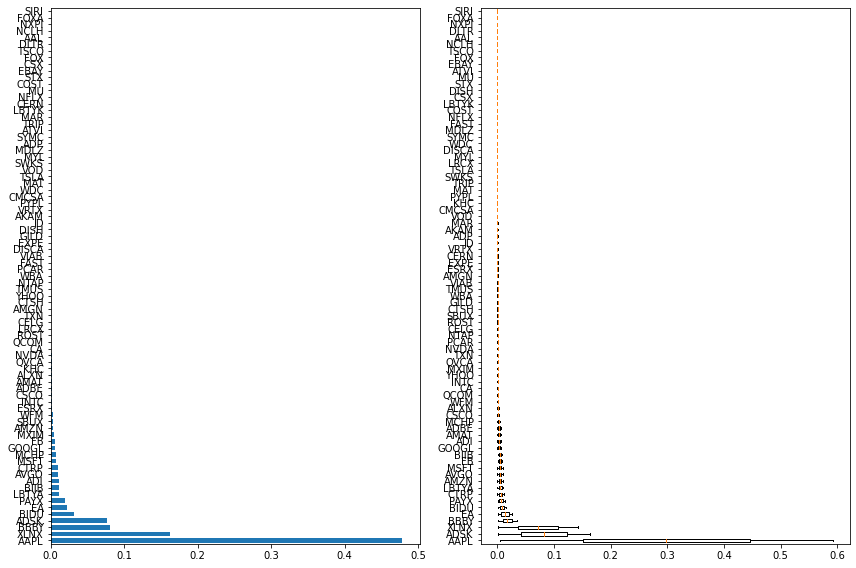

In [23]:
feature_perm = df_perm
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp

tree_indices = np.arange(0, len(feature_imp)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.barh(tree_indices,feature_imp['imps'].values, height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(feature_imp['cols'].values)
ax1.set_ylim((0, len(feature_imp)))

ax2.boxplot(feature_perm, vert=False,labels=feature_perm.index.values)
fig.tight_layout()
plt.show()

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/NASDAQ_FEATURE3.png?raw=true">

# Sélection des variables par méthode RFE

In [ ]:
from sklearn.feature_selection import RFE

# Informations sur les données
n = 40560             # Nombre d'observations
p = 81                # Nombre de variables
n_arbres = 2000
m_try = "auto"

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)
rfe = RFE(estimator=clf, n_features_to_select=3, step=1, verbose=1)
rfe.fit(X, tf.squeeze(np.asarray(Y),1))

In [ ]:
X

In [ ]:
rfe.ranking_

array([1, 1, 2, 3, 1])

# Sélection des variables par méthode RFE-CV

In [ ]:
from sklearn.feature_selection import RFECV

# Informations sur les données
n = 27553             # Nombre d'observations
p = 5                 # Nombre de variables
n_arbres = 500
m_try = 5
min_features_to_select = 1

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features="auto", n_jobs=-1)
rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='neg_mean_absolute_error',min_features_to_select=min_features_to_select, verbose=1)
rfecv.fit(X, tf.squeeze(np.asarray(Y),1))

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/ResultRFECV_Nasdaq.png?raw=true" width=400>

In [ ]:
rfecv.ranking_

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/ResultRFECV_Nasdaq2.png?raw=true" width=700>

#Extraction des données pour VSURF

In [6]:
X = df_etude.iloc[:,:-1]
X

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,AMZN,ATVI,AVGO,BBBY,BIDU,BIIB,CA,CELG,CERN,CMCSA,COST,CSCO,CSX,CTRP,CTSH,DISCA,DISH,DLTR,EA,EBAY,ESRX,EXPE,FAST,FB,FOX,FOXA,GILD,GOOGL,INTC,JD,...,LBTYA,LBTYK,LRCX,MAR,MAT,MCHP,MDLZ,MSFT,MU,MXIM,MYL,NCLH,NFLX,NTAP,NVDA,NXPI,PAYX,PCAR,PYPL,QCOM,QVCA,ROST,SBUX,SIRI,STX,SWKS,SYMC,TMUS,TRIP,TSCO,TSLA,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO
0,35.980000,96.800003,97.800003,61.150002,95.400002,58.180000,58.000000,127.040001,26.680000,165.809998,742.119995,42.299999,161.410004,44.209999,159.889999,286.320007,34.570000,106.050003,62.070000,67.339996,167.600006,30.790001,28.370001,43.520000,58.400002,25.420000,52.439999,96.550003,76.949997,30.600000,76.540001,117.879997,41.990002,121.940002,27.500000,26.860001,84.000000,756.570007,34.770000,21.799999,...,31.100,30.209999,91.239998,71.110001,32.779999,54.779999,45.689999,56.514999,14.000000,39.200001,47.130001,41.900002,91.000000,26.440001,56.198399,85.230003,60.740002,56.169998,37.770000,60.950001,26.740000,61.130001,58.578999,4.280,31.350000,65.360001,20.370001,44.950001,70.050003,91.410004,227.649994,70.730003,45.230000,31.170099,95.269997,81.364998,52.160000,33.950001,48.610001,38.009998
1,35.931000,96.889999,97.800003,61.610001,95.411499,58.189999,58.119999,126.059998,26.730000,165.910095,741.919983,42.439999,161.830002,44.090000,160.130005,286.809998,34.580002,105.544998,61.930000,67.300003,167.820007,30.840000,28.462500,43.520000,58.330002,25.410000,52.110001,96.820000,77.070000,30.740000,76.440002,117.989998,41.900002,121.745003,27.480000,26.870001,83.970001,756.159973,34.919998,21.850000,...,31.225,30.430000,91.330002,70.849998,32.790001,54.889999,45.730000,56.720001,14.000000,39.369999,47.150002,41.810001,91.160004,26.450001,56.415001,86.175003,60.935001,56.849998,37.740002,60.919998,26.719999,61.430000,58.480000,4.270,31.010000,65.250000,20.410000,44.974998,70.230003,91.050003,227.096695,70.690002,45.009998,31.190001,94.169998,81.540001,52.150002,34.099998,48.740002,38.139999
2,35.904400,96.949997,97.570000,61.980000,95.510002,58.203335,57.950001,126.510002,26.712000,166.179993,739.599976,42.459999,162.500000,43.860001,160.000000,286.130005,34.590000,106.578697,61.916668,67.230003,167.960007,30.879999,28.389999,43.540001,58.340000,25.379999,52.106667,96.889999,77.250000,30.799999,76.089996,118.629997,41.735001,121.452003,27.410000,26.820000,84.000000,755.619995,34.919201,21.770000,...,31.010,30.170000,91.370003,70.779999,32.830002,55.139999,45.799999,56.700001,14.005600,39.380001,47.130001,41.865002,91.360001,26.389999,56.490002,85.680099,61.000000,57.500000,37.711700,61.029999,26.660000,61.549999,58.509998,4.285,31.195000,65.410004,20.389999,44.810001,70.092499,91.180000,226.630005,71.300003,45.014999,31.209999,94.749001,81.529999,52.270000,34.009998,48.990002,38.150002
3,35.889999,96.970001,97.550003,62.090000,95.519997,58.216667,57.959999,126.279999,26.740000,166.147995,739.549988,42.520000,162.679993,43.799999,160.119995,286.799988,34.610001,106.349998,61.903332,67.379997,167.850006,30.889999,28.389999,43.549999,58.540001,25.370001,52.103333,96.760002,76.959999,30.860001,75.650002,118.570000,41.709999,121.449997,27.420000,26.870001,83.339996,756.359924,34.951000,21.809999,...,30.900,30.100000,91.419998,70.875000,32.860001,55.310001,45.790001,56.689999,14.057300,39.419998,47.115002,41.919998,92.279999,26.395500,56.533501,85.665001,61.007999,57.750000,37.825001,61.130001,26.730000,61.500000,58.470001,4.280,31.139999,65.239998,20.370001,44.689999,69.955002,91.279999,227.529999,71.309998,45.020000,31.209999,94.309998,81.709999,52.299999,33.959999,48.950001,38.195000
4,36.007999,96.959999,97.730003,61.889999,95.529999,58.230000,58.209999,126.584999,26.719999,165.990005,738.719971,42.610001,162.750000,43.919998,160.860001,286.420013,34.619999,106.000000,61.889999,67.300003,168.440002,30.875000,28.389999,43.630001,58.560001,25.320000,52.099998,96.760002,77.029999,30.889999,76.500000,118.419998,41.820000,121.379997,27.400000,26.83000

In [7]:
Y = df_etude.iloc[:,-1:]
Y

,NDX
0,4665.054199
1,4665.054199
2,4665.826172
3,4667.081055
4,4664.491211
...,...
40555,4921.811035
40556,4921.580078
40557,4921.883789
40558,4922.949219


In [ ]:
from google.colab import files

X.to_csv("XNAS.csv")
Y.to_csv("YNAS.csv")

files.download("XNAS.csv")
files.download("YNAS.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Sélection des variables par tests de collinéarité VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#function for removing features with high vif
def drop_high_vif(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

#function for listing vif values
def vif_values(X):
    add_constant(X)
    df=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    return df


In [ ]:
X_reduit_VIF = drop_high_vif(X,thresh=20)
X_reduit_VIF

In [ ]:
import seaborn as sns

corr = X_reduit_VIF.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')